In [1]:
import json
import re
import sys
import pandas as pd
import numpy as np

In [2]:
!pip install torch torchvision transformers

In [3]:
!pip install emoji

## Preprocessing

Load tweet data and perform preprocessing via `dataloader`

In [5]:

train_df = pd.read_csv('train_sr.csv')
dev_df = pd.read_csv('dev_sr.csv')
test_df = pd.read_csv('test_sr.csv')

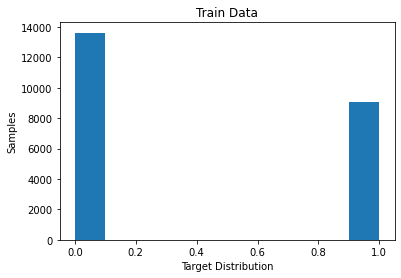

In [6]:
import matplotlib.pyplot as plt
plt.title('Train Data')
plt.xlabel('Target Distribution')
plt.ylabel('Samples')
plt.hist(train_df.label)
plt.show()

In [7]:
train_df

,Unnamed: 0,text,label,index
0,0,5. Can regularly rinsing your nose with saline...,0,0
1,1,5. Can regularly rinsing your nose with saline...,0,0
2,2,5. Can regularly rinsing your nose with saline...,0,0
3,3,5. Can regularly rinsing your nose with saline...,0,0
4,4,5. Can regularly rinsing your nose with saline...,0,0
...,...,...,...,...
22680,22680,@lynneSimpkin I can help! 👩‍🏫\n9am: Socialism ...,0,1894
22681,22681,@lynneSimpkin I can help! 👩‍🏫\n9am: Socialism ...,0,1894
22682,22682,@lynneSimpkin I can help! 👩‍🏫\n9am: Socialism ...,0,1894
22683,22683,@lynneSimpkin I can help! 👩‍🏫\n9am: Socialism ...,0,1894


In [8]:
train_df['text'][5]

'5. Can regularly rinsing your nose with saline help prevent infection with the new coronavirus? https://t.co/ccMjhhD7BK [SEP] [CLS] 10. Are hand dryers effective in killing the new coronavirus? https://t.co/cSDKXO1bGr'

## Loading BertTokenizer

Load tokenizer from BERT

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [10]:
import tensorflow as tf 

## BERT encoding

Data is encoded according to BERT requirement.

1. Tokenize the text
2. Add [CLS] and [SEP] token
3. Pad the sentences to sequence length of 512

In [11]:
def bert_encode(data, maximum_sequence_length) :
    input_ids = []
    attention_masks = []


    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_sequence_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation = True
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

The input to BERT are two numpy arrays:

1) input_ids : list of token ids to be fed to a model

2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

## Create custom BERT Model

This BERT mdoel uses  TFBertModel with a dense layer and sigmoid activation.

In [12]:
# Define f1 metric
# Code from https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
from keras import backend as K

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

    
def f1(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2*((precision_value*recall_value) / (precision_value+recall_value+K.epsilon()))

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(300,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(300,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    return model

In [14]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# TFBertModel for local development

This BERT model was used for development purposes and makes use of the validation set to evaluate the performance on the given task.

In [16]:
train_input_ids,train_attention_masks = bert_encode(train_df,300)
dev_input_ids,dev_attention_masks = bert_encode(dev_df,300)
test_input_ids,test_attention_masks = bert_encode(test_df,300)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Training

Fit for 7 epochs:

In [17]:
validation_data = ([dev_input_ids, dev_attention_masks], dev_df.label)

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 7
batch_size = 16

In [19]:
history = model.fit([train_input_ids,train_attention_masks], train_df.label, validation_data=validation_data ,callbacks=[callback], epochs=epochs, batch_size=batch_size)

Epoch 1/7
1418/1418 [==============================] - 1663s 1s/step - loss: 0.1240 - accuracy: 0.9523 - recall: 0.9350 - precision: 0.9458 - f1: 0.9347 - val_loss: 0.2197 - val_accuracy: 0.9351 - val_recall: 0.4574 - val_precision: 0.4743 - val_f1: 0.4623
Epoch 2/7
1418/1418 [==============================] - 1647s 1s/step - loss: 0.0127 - accuracy: 0.9974 - recall: 0.9963 - precision: 0.9973 - f1: 0.9964 - val_loss: 0.2321 - val_accuracy: 0.9383 - val_recall: 0.4761 - val_precision: 0.4843 - val_f1: 0.4769
Epoch 3/7
1418/1418 [==============================] - 1647s 1s/step - loss: 0.0038 - accuracy: 0.9993 - recall: 0.9987 - precision: 0.9995 - f1: 0.9990 - val_loss: 0.3625 - val_accuracy: 0.9319 - val_recall: 0.4550 - val_precision: 0.4662 - val_f1: 0.4569
Epoch 4/7
1418/1418 [==============================] - 1648s 1s/step - loss: 0.0034 - accuracy: 0.9993 - recall: 0.9982 - precision: 0.9986 - f1: 0.9983 - val_loss: 0.4121 - val_accuracy: 0.9364 - val_recall: 0.4581 - val_precisi

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['f1']
val_f1 = history.history['val_f1']

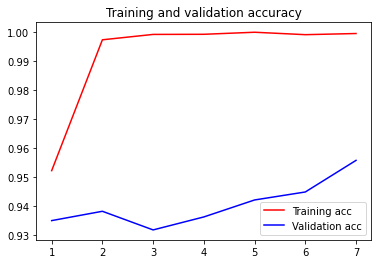

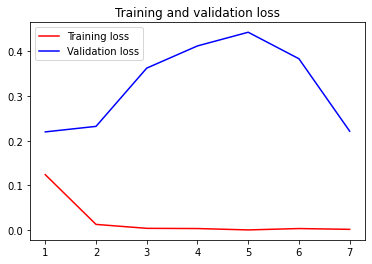

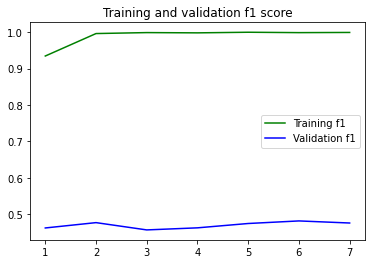

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', color = "red", label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color="red", label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, f1, 'b', color = "green", label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
model.save("/content/drive/MyDrive/Colab/tfmodel_sr1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/tfmodel_sr1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/tfmodel_sr1/assets


In [ ]:
model.save("./pure_bert/pure_bert_v11")

INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v11/assets


INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v11/assets


## Inference

In [26]:
result_dev = model.predict([dev_input_ids, dev_attention_masks])

In [28]:
from collections import Counter, defaultdict
pred_scores = result_dev

index_list = list(dev_df['index'])
label_all = list(dev_df['label'])

counter = Counter(index_list)
proba_sum = defaultdict(float)
label_sum = defaultdict(int)

for i in range(len(index_list)):
  proba_sum[index_list[i]] += pred_scores[i]
  label_sum[index_list[i]] += label_all[i]
pred_labels = []
proba_list = []
label_list = []
for i in sorted(list(proba_sum.keys())):
  proba = 0
  label = 0
  proba_list.append(proba_sum[i]/counter[i])
  label_list.append(int(label_sum[i]/counter[i]))
  if proba_sum[i]/counter[i]>0.5:
    label = 1
  pred_labels.append(label)

print(len(proba_list))
print(len(label_list))

537
537


In [29]:
import sklearn.metrics as metrics

print(metrics.accuracy_score(label_list, pred_labels))
print(metrics.precision_score(label_list, pred_labels))
print(metrics.recall_score(label_list, pred_labels))
print(metrics.roc_auc_score(label_list, proba_list))

0.9757914338919925
0.9636363636363636
0.9217391304347826
0.9930970533690502


In [30]:
result_test = model.predict([test_input_ids, test_attention_masks])

In [32]:
pred_scores = result_test

index_list = list(test_df['index'])

from collections import Counter, defaultdict
counter = Counter(index_list)
proba_sum = defaultdict(float)

for i in range(len(index_list)):
  proba_sum[index_list[i]] += pred_scores[i]

pred_labels = []
for i in sorted(list(proba_sum.keys())):
  label = 0
  if proba_sum[i]/counter[i]>0.5:
    label = 1
  pred_labels.append(label)

with open('test.predictions_tf1.txt', 'w') as output:
  output.write('Id,Predicted\n')
  counter = 0
  for elem in pred_labels:
    output.write(str(counter) + ',' + str(elem)+'\n')
    counter+=1
  

In [ ]:
result = model.predict([test_input_ids, test_attention_masks])
result = np.round(result).astype(int)
#pred_labels = np.argmax(result, axis = 1)

#predicted_labels = [dataloader.convert_prediction(pred) for pred in result]
#output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
#output

In [ ]:
#result

In [ ]:
with open('test.predictions.txt', 'w') as output:
  output.write('Id,Predicted\n')
  counter = 0
  for elem in list(result):
    for elem2 in list(elem):
      output.write(str(counter) + ',' + str(elem2)+'\n')
      counter+=1



######### 目前输出截止到这里

In [ ]:
output

In [ ]:
def convert_label(label):
    if label == "rumour":
        return 1
    elif label == "non-rumour":
        return 0
    else:
        raise Exception("label classes must be 'rumour' or 'non-rumour'")
        
        
def convert_prediction(pred):
    if pred == 1:
        return "rumour"
    elif pred == 0:
        return "nonrumour"
    else:
        raise Exception("prediction classes must be '0' or '1'")

In [ ]:
predicted_labels = [convert_prediction(pred) for pred in result]
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

In [ ]:
output

In [ ]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output_v11.json', 'w') as f:
    json.dump(submission, f)

# BERT model from Huggingface Hub for CodaLab competition

For the CodaLab compeition, the train and development dataset has been merged to increase the size of the training set.

In [ ]:
combined_df = train_df.append(dev_df, ignore_index = True)
combined_df

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,reputation_score_2,favourites_count,verified,geo_enabled,has_description,length_description,source_tweet,replies,hashtags,label
0,552800070199148544,how to respond to the murderous attack on char...,228,77,True,False,0,True,27923,185,...,0.908971,500,False,False,True,46,how to respond to the murderous attack on char...,[jews label anyone they do not like as anti se...,[imcharliehebdo],0
1,544388259359387648,you can not condemn an entire race nation or ...,352,252,False,False,0,False,745,2,...,0.413158,428,False,False,True,115,you can not condemn an entire race nation or ...,[how many times are we going to have the do n...,"[sydneysiege, sydneysiege, leftistluzer, sydne...",0
2,552805970536333314,attempts to extend blame for this to all musli...,876,400,False,False,0,False,74137,1431,...,0.954630,6423,False,True,True,149,attempts to extend blame for this to all musli...,[when will we see mass protests from amoderat...,"[charliehebdo, nonmuslimlivesmatter]",0
3,525071376084791297,rest in peace cpl nathan cirillo killed tod...,112,96,False,True,1,True,28103,418,...,0.933548,2140,True,True,True,157,rest in peace cpl nathan cirillo killed tod...,"[hot guy, hey frizz i was right downtown crazy...","[ottawashooting, ottawashooting, ottawashootin...",1
4,498355319979143168,people debating whether mikebrown shoplifted o...,802,298,False,False,0,False,55920,65,...,0.678947,25389,False,False,True,156,people debating whether mikebrown shoplifted o...,[yeah and shooting him times while not even...,"[mikebrown, ferguson, mikebrown, mikebrown, mi...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,525025279803424768,the soldier shot dead in wednesday is ottawa a...,119,36,False,False,0,True,88483,306,...,0.727071,1903,True,True,True,101,the soldier shot dead in wednesday is ottawa a...,"[my condolences go out to your family, that ...","[hamont, ottawashooting, notinvain]",1
5217,552784600502915072,charlie hebdo became well known for publishing...,202,41,False,False,0,False,15128,1657,...,0.948267,0,True,True,True,158,charlie hebdo became well known for publishing...,[i am muslim would you call me violent even ...,[islamphobiaatitsbest],0
5218,499696525808001024,we got through that is a sniper on top of a t...,432,55,False,True,1,False,61902,1627,...,0.982027,1163,False,True,True,159,we got through that is a sniper on top of a t...,[we got through that is a sniper on top of a ...,"[ferguson, ferguson, ferguson, responsiblejour...",0
5219,580320612155060224,last position of germanwings flight u at ...,3092,480,False,True,1,True,7991,2384,...,0.998276,1131,True,True,True,146,last position of germanwings flight u at ...,[where was the pilot how come he did not use ...,"[4u9525, 4u9525, 4u9525, 4u9525, 4u9525, 4u952...",1


In [ ]:
combined_input_ids,combined_attention_masks = bert_encode(combined_df,512)
test_input_ids,test_attention_masks = bert_encode(test_df,512)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Training

Fit for 7 epochs:

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 7
batch_size = 4

In [ ]:
history = model.fit([combined_input_ids,combined_attention_masks],combined_df.label,validation_split=0,callbacks=[callback], epochs=epochs,batch_size=batch_size)

Epoch 1/7
1306/1306 [==============================] - 1215s 917ms/step - loss: 0.5511 - accuracy: 0.7157 - recall: 0.3364 - precision: 0.3670 - f1: 0.3318
Epoch 2/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.3281 - accuracy: 0.8573 - recall: 0.6496 - precision: 0.6434 - f1: 0.6242
Epoch 3/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.2103 - accuracy: 0.9158 - recall: 0.7516 - precision: 0.7381 - f1: 0.7317
Epoch 4/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.1305 - accuracy: 0.9528 - recall: 0.7286 - precision: 0.7216 - f1: 0.7176
Epoch 5/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.0714 - accuracy: 0.9764 - recall: 0.7915 - precision: 0.7898 - f1: 0.7862
Epoch 6/7
1306/1306 [==============================] - 1198s 917ms/step - loss: 0.0391 - accuracy: 0.9871 - recall: 0.7993 - precision: 0.8014 - f1: 0.7981
Epoch 7/7
1306/1306 [==============================] - 1198s 917

In [ ]:
model.save("./pure_bert/pure_bert_v38")

INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v38/assets


INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v38/assets


## Inference

In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)
predicted_labels = [dataloader.convert_prediction(pred) for pred in result]
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

In [ ]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output_v38.json', 'w') as f:
    json.dump(submission, f)